In [44]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [45]:
# 超参数设置
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28
INPUT_SIZE = 28
LR = 0.01
DOWNLOAD_MNIST = False

train训练集大小:  torch.Size([60000, 28, 28])
train标签大小:  torch.Size([60000])


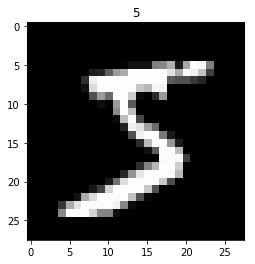

In [46]:
path = os.path.join(".", "datasets/mnists")
train_data = dsets.MNIST(
    path, 
    train=True, 
    transform=transforms.ToTensor(),   # 转换 PIL.Image or numpy.ndarray成 torch.FloatTensor of shape (n_c x n_h x n_w) and normalize in the range [0.0, 1.0] 
    download=DOWNLOAD_MNIST
) 

print("train训练集大小: ", train_data.train_data.size()) 
print("train标签大小: ", train_data.train_labels.size())   
# 显示其中的一个样本
plt.imshow(train_data.train_data[0].numpy(), cmap="gray")
plt.title("%i" % train_data.train_labels[0]);

In [47]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data = dsets.MNIST(path, train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:20000]/255
test_y = test_data.test_labels.numpy()[:20000]



In [48]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size = 28, # 图片每行的数据像素点
            hidden_size = 64, # rnn hidden unit
            num_layers = 1, # 有几层 RNN layers
            batch_first = True, # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
        ) # LSTM 效果要比 nn.RNN() 好多了
        self.output = nn.Linear(64, 10)  # 输出层
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None 表示 hidden state 会用全0的 state
        # 选取最后一个时间点的 r_out 输出
        # 这里 r_out[:, -1, :] 的值也是 h_n 的值
        out = self.output(r_out[:, -1, :])
        return out
        
rnn = RNN()
rnn

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [49]:
# 定义优化器
optimizers = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [50]:
# 训练
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.view(-1, 28, 28)  # reshape x to (batch, time_step, input_size)
        output = rnn(batch_x)
        loss = loss_func(output, batch_y)
        optimizers.zero_grad()
        loss.backward()
        optimizers.step()
        if step % 50 == 0:
            test_output = rnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            acc = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print("经过%d次训练后，train上的loss值是:%.4f, 测试集上的精度是:%.2f" % (step, loss.data.numpy(), acc))




经过0次训练后，train上的loss值是:2.3033, 测试集上的精度是:0.10
经过50次训练后，train上的loss值是:1.1740, 测试集上的精度是:0.68
经过100次训练后，train上的loss值是:0.6985, 测试集上的精度是:0.76
经过150次训练后，train上的loss值是:0.5847, 测试集上的精度是:0.86
经过200次训练后，train上的loss值是:0.5073, 测试集上的精度是:0.89
经过250次训练后，train上的loss值是:0.3764, 测试集上的精度是:0.90
经过300次训练后，train上的loss值是:0.3147, 测试集上的精度是:0.92
经过350次训练后，train上的loss值是:0.2273, 测试集上的精度是:0.92
经过400次训练后，train上的loss值是:0.2136, 测试集上的精度是:0.93
经过450次训练后，train上的loss值是:0.2066, 测试集上的精度是:0.94
经过500次训练后，train上的loss值是:0.2148, 测试集上的精度是:0.95
经过550次训练后，train上的loss值是:0.2961, 测试集上的精度是:0.94
经过600次训练后，train上的loss值是:0.1678, 测试集上的精度是:0.96
经过650次训练后，train上的loss值是:0.1117, 测试集上的精度是:0.96
经过700次训练后，train上的loss值是:0.3467, 测试集上的精度是:0.95
经过750次训练后，train上的loss值是:0.3730, 测试集上的精度是:0.95
经过800次训练后，train上的loss值是:0.0663, 测试集上的精度是:0.96
经过850次训练后，train上的loss值是:0.1001, 测试集上的精度是:0.96
经过900次训练后，train上的loss值是:0.1253, 测试集上的精度是:0.96


In [51]:
# 在测试集上的效果
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print("预测数字: ", pred_y)
print("真实数字: ", test_y[:10])

预测数字:  [7 2 1 0 4 1 4 9 6 9]
真实数字:  [7 2 1 0 4 1 4 9 5 9]
